# Probabilistic  Programming,  Parameter estimation and hypothesis testing

In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
from ipywidgets import interact
import arviz as az
%matplotlib inline
sns.set()

## Learning Objectives of Part 2-b

1. Consolidate your knowledge of the Bayesian model building workflow and use probabilistic programming for parameter estimation;
2. Use probabilistic programming for hypothesis testing.

## 1. Bayesian parameter estimation using PyMC3

Well done! You've learnt the basics of Bayesian model building. The steps are
1. To completely specify the model in terms of _probability distributions_. This includes specifying 
    - what the form of the sampling distribution of the data is _and_ 
    - what form describes our _uncertainty_ in the unknown parameters (This formulation is adapted from [Fonnesbeck's workshop](https://github.com/fonnesbeck/intro_stat_modeling_2017/blob/master/notebooks/2.%20Basic%20Bayesian%20Inference.ipynb) as Chris said it so well there).
2. Calculate the _posterior distribution_.

In the above, the form of the sampling distribution of the data was Binomial (described by the likelihood) and the uncertainty around the unknown parameter $p$ captured by the prior.

Now it is time to do the same using the **probabilistic programming language** PyMC3. There's _loads of cool stuff_ about PyMC3 and this paradigm, two of which are
- _probabililty distributions_ are first class citizens, in that we can assign them to variables and use them intuitively to mirror how we think about priors, likelihoods & posteriors.
- PyMC3 calculates the posterior for us!

Under the hood, PyMC3 will compute the posterior using a sampling based approach called Markov Chain Monte Carlo (MCMC) or Variational Inference. Check the [PyMC3 docs](https://docs.pymc.io/) for more on these. 

But now, it's time to bust out some MCMC and get sampling!

### Parameter estimation I: click-through rate

A common experiment in tech data science is to test a product change and see how it affects a metric that you're interested in. Say that I don't think enough people are clicking a button on my website & I hypothesize that it's because the button is a similar color to the background of the page. Then I can set up two pages and send some people to each: the first the original page, the second a page that is identical, except that it has a button that is of higher contrast and see if more people click through. This is commonly referred to as an A/B test and the metric of interest is click-through rate (CTR), what proportion of people click through. Before even looking at two rates, let's use PyMC3 to estimate one.



First generate click-through data, given a CTR $p_a=0.15$.

In [2]:
# click-through rates
p_a = 0.15
N = 150
n_successes_a = np.sum(np.random.binomial(N, p_a))

Now it's time to build your probability model. Noticing that our model of having a constant CTR resulting in click or not is a biased coin flip,
- the sampling distribution is binomial and we need to encode this in the likelihood;
- there is a single parameter $p$ that we need to describe the uncertainty around, using a prior and we'll use a uniform prior for this.

These are the ingredients for the model so let's now build it:

In [3]:
# Build model of p_a
with pm.Model() as Model:
    # Prior on p
    prob = pm.Uniform('p')
    # Binomial Likelihood
    y = pm.Binomial('y', n=N, p=prob, observed=n_successes_a)

**Discussion:** 
- What do you think of the API for PyMC3. Does it reflect how we think about model building?

It's now time to sample from the posterior using PyMC3. You'll also plot the posterior:

In [4]:
with Model:
    samples = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]
100%|██████████| 2500/2500 [00:00<00:00, 2586.96it/s]


/anaconda3/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


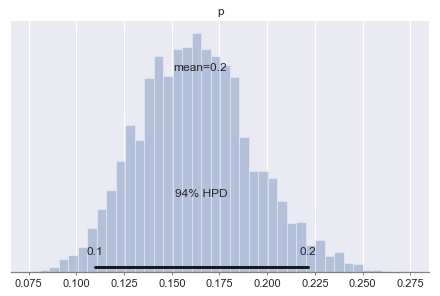

In [5]:
az.plot_posterior(samples, kind='hist');

**For discussion:** Interpret the posterior ditribution. What would your tell the non-technical manager of your growth team about the CTR?

### Hands-on: Parameter estimation II -- the mean of a population

In this exercise, you'll calculate the  posterior mean beak depth of Galapagos finches in a given species. First you'll load the data and subset wrt species:

In [6]:
# Import and view head of data
df_12 = pd.read_csv('../data/finch_beaks_2012.csv')
df_fortis = df_12.loc[df_12['species'] == 'fortis']
df_scandens = df_12.loc[df_12['species'] == 'scandens']

To specify the full probabilty model, you need
- a likelihood function for the data &
- priors for all unknowns.

What is the likelihood here? Let's plot the measurements below and see that they look approximately Gaussian/normal so you'll use a normal likelihood $y_i\sim \mathcal{N}(\mu, \sigma^2)$. The unknowns here are the mean $\mu$ and standard deviation $\sigma$ and we'll use weakly informative priors on both
- a normal prior for $\mu$ with mean $10$ and standard deviation $5$;
- a uniform prior for $\sigma$ bounded between $0$ and $10$.

We can discuss biological reasons for these priors also but you can also test that the posteriors are relatively robust to the choice of prior here due to the amount of data.

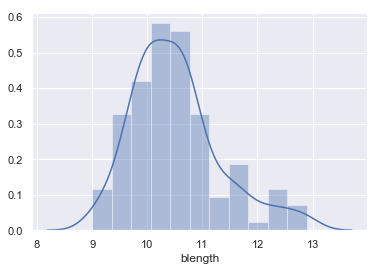

In [7]:
sns.distplot(df_fortis['blength']);

In [8]:
with pm.Model() as model:
    # Prior for mean & standard deviation
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Lognormal('σ_1', 0, 10)
    # Gaussian Likelihood
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis['blength'])

In [9]:
# bust it out & sample
with model:
    samples = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_1, μ_1]
100%|██████████| 2500/2500 [00:01<00:00, 1934.66it/s]


/anaconda3/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


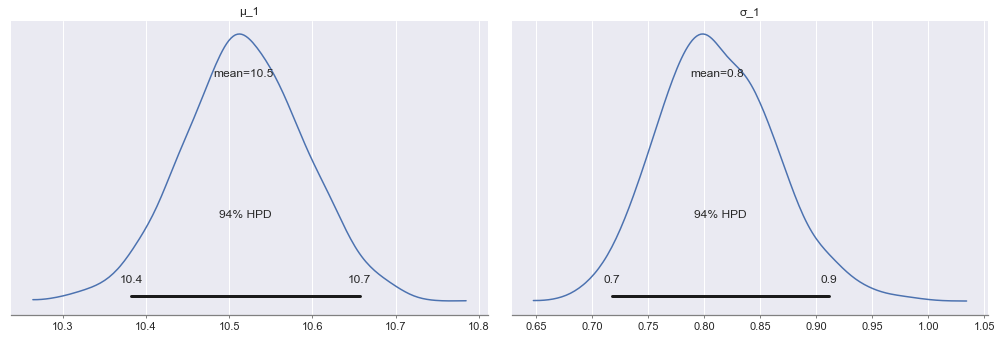

In [10]:
    az.plot_posterior(samples);

## 2. Bayesian Hypothesis testing

### Bayesian Hypothesis testing I: A/B tests on click through rates

Assume we have a website and want to redesign the layout (*A*) and test whether the new layout (*B*) results in a higher click through rate. When people come to our website we randomly show them layout *A* or *B* and see how many people click through for each. First let's generate the data we need:

In [11]:
# click-through rates
p_a = 0.15
p_b = 0.20
N = 1000
n_successes_a = np.sum(np.random.uniform(size=N) <= p_a)
n_successes_b = np.sum(np.random.uniform(size=N) <= p_b)

Once again, we need to specify our models for $p_a$ and $p_b$. Each will be the same as the CTR example above
- Binomial likelihoods
- uniform priors on $p_a$ and $_p$.

We also want to calculate the posterior of the difference $p_a-p_b$ and we do so using `pm.Deterministic()`, which specifies a deterministic random variable, i.e., one that is completely determined by the values it references, in the case $p_a$ & $p_b$.

We'll now build the model:

In [12]:
with pm.Model() as Model:
    # Prior on p
    prob_a = pm.Uniform('p_a')
    prob_b = pm.Uniform('p_b')
    # Binomial Likelihood
    y_a = pm.Binomial('y_a', n=N, p=prob_a, observed=n_successes_a)
    y_b = pm.Binomial('y_b', n=N, p=prob_b, observed=n_successes_b)
    diff_clicks = pm.Deterministic('diff_clicks', prob_a-prob_b)

Sample from the posterior and plot them:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_b, p_a]
100%|██████████| 2500/2500 [00:01<00:00, 1990.07it/s]


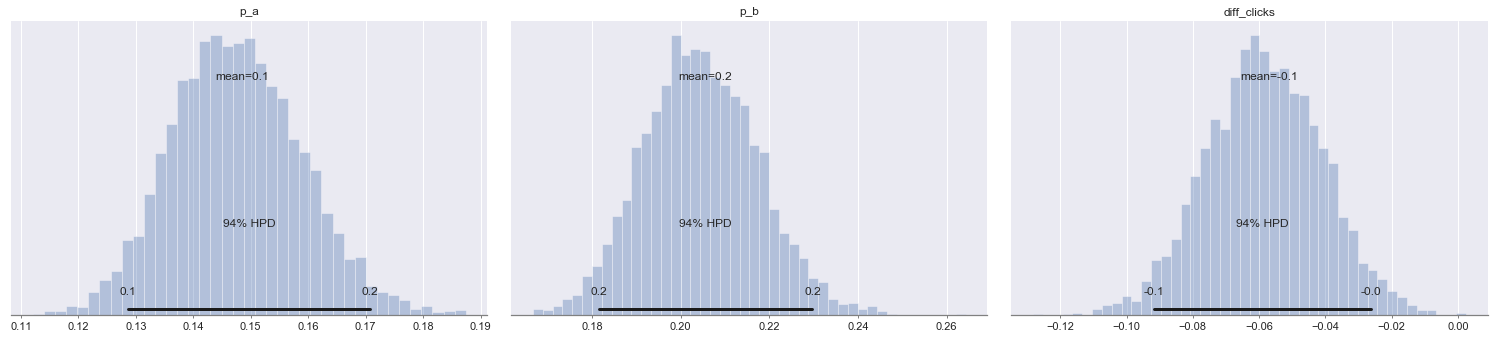

In [13]:
with Model:
    samples = pm.sample(2000, njobs=1)
az.plot_posterior(samples, kind='hist');

### Hands-on: Bayesian Hypothesis testing II -- beak lengths difference between species

**Task**: Determine whether the mean beak length of the Galapogas finches differs between species. For the mean of each species, use the same model as in previous hand-on section:

- Gaussian likelihood;
- Normal prior for the means;
- Uniform prior for the variances.

Also calculate the difference between the means and, for bonus points, the _effect size_, which is the difference between the means divided by the pooled standard deviations = $\sqrt{(\sigma_1^2+\sigma_2^2)/2}$. Hugo will talk through the importance of the _effect size_.

Don't forget to sample from the posteriors and plot them!

In [14]:
with pm.Model() as model:
    # Priors for means and variances
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Uniform('σ_1', 0, 10)
    μ_2 = pm.Normal('μ_2', mu=10, sd=5)
    σ_2 = pm.Uniform('σ_2', 0, 10)
    # Gaussian Likelihoods
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis['blength'])
    y_2 = pm.Normal('y_2', mu=μ_2, sd=σ_2, observed=df_scandens['blength'])
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', μ_1 - μ_2)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(σ_1, 2) + 
                                         np.power(σ_2, 2)) / 2)
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_2, μ_2, σ_1, μ_1]
100%|██████████| 2500/2500 [00:02<00:00, 1216.14it/s]


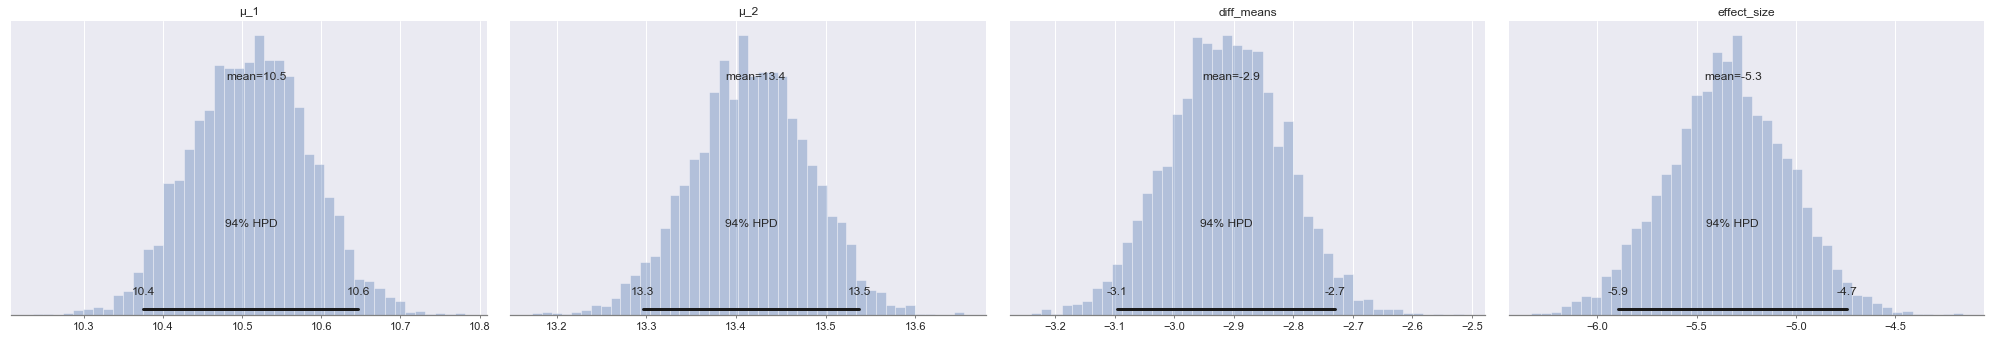

In [15]:
# bust it out & sample
with model:
    samples = pm.sample(2000, njobs=1)
az.plot_posterior(samples, var_names=['μ_1', 'μ_2', 'diff_means', 'effect_size'], kind='hist');